# Stochastic Volume Calculations

As we saw in previous sessions, knowing the volume of different regions in a model can be important for tally normalization. We calculated volumes analytically, but there are often regions in models that are difficult or impossible to compute analytically. For these regions, we can use OpenMC's stochastic volume calculation mode.

In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

In [2]:
model = openmc.examples.pwr_core()

<Figure size 720x720 with 0 Axes>

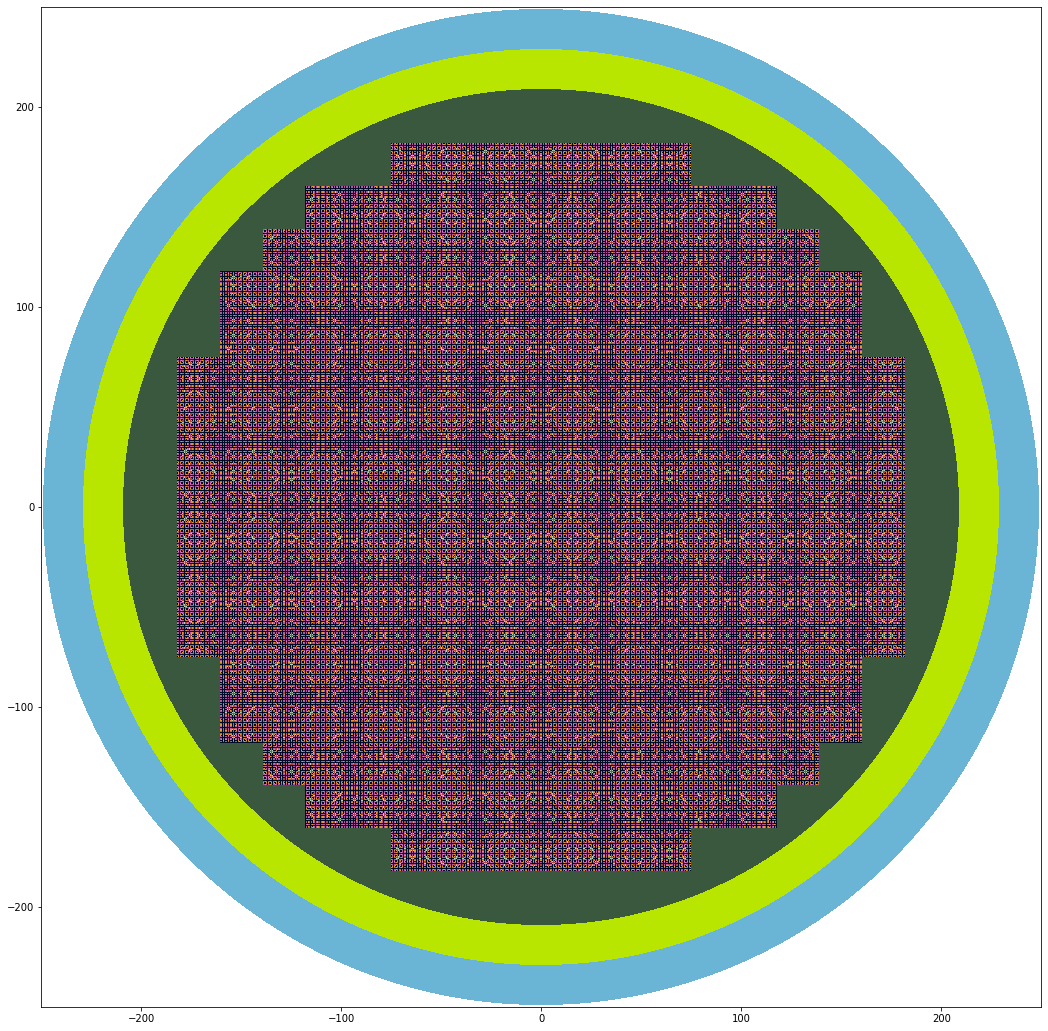

In [3]:
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(500, 500), pixels=(1000, 1000))

<Figure size 720x720 with 0 Axes>

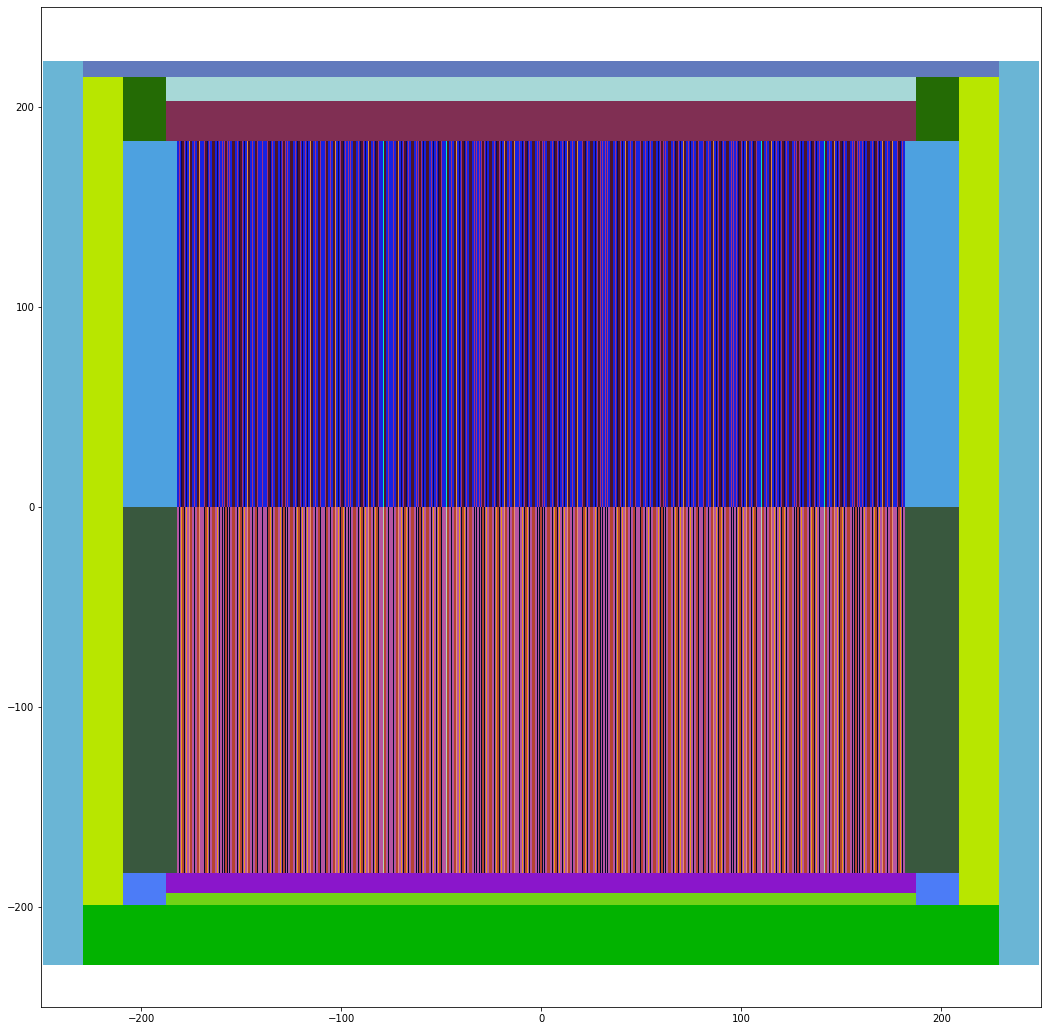

In [4]:
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(500, 500), pixels=(1000, 1000), basis='xz')

<Figure size 720x720 with 0 Axes>

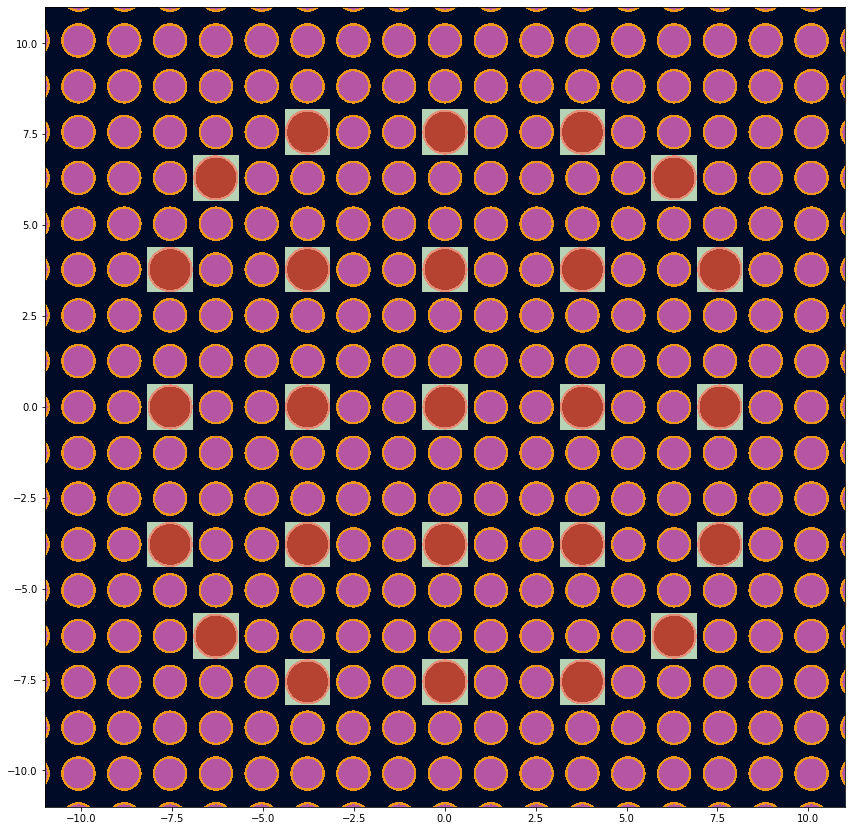

In [5]:
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(22, 22), origin=(0, 0, 0), pixels=(800, 800))

This model doesn't contain any particularly complex geometry, but there are still regions for which it would be onerous to compute volumes analytically.

<Figure size 720x720 with 0 Axes>

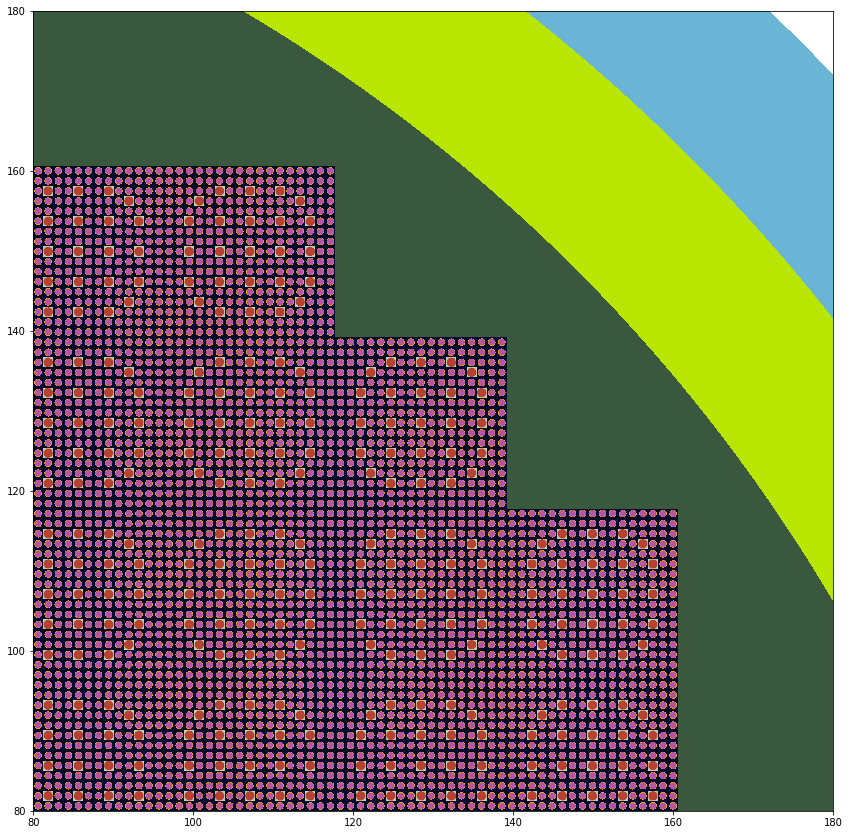

In [6]:
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(100, 100), origin=(130, 130, 0), pixels=(800, 800))

Now let's setup a volume calculation object. Volumes can be computed using a few different domain types: materials, cells, and universes. The number of atoms for different nuclides can be computed as well based on the volumes of materials and their various atom percentages.

Volume calculations are performed by randomly selecting locations in a specified bounding box. The number of locations for where a domain item (cell, material, universe) is found indicates how much of the bounding box is occupied by this item.

$$ V_{i} = \frac{N_{i}}{N} V_{box}$$

This straightforward method is a relative to one of the most well-known uses of Monte Carlo, [the computation of $\pi$](https://blogs.sas.com/content/iml/2016/03/14/monte-carlo-estimates-of-pi.html#:~:text=To%20compute%20Monte%20Carlo%20estimates,the%20curve%20is%20%CF%80%20%2F%204.).

Let's setup a volume calculation using the materials from this PWR core model. Typically, OpenMC attempts to automatically compute a bounding box for a model, but in this case the plots above give us an idea of that this is.

In [7]:
lower_left = (-250, -250, -250)
upper_right = (250, 250, 250)

In [8]:
materials = model.materials
print(len(materials))
print(materials[:2])

12
[Material
	ID             =	1
	Name           =	UOX fuel
	Temperature    =	None
	Density        =	10.062 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U234           =	4.9476e-06   [ao]
	U235           =	0.00048218   [ao]
	U238           =	0.021504     [ao]
	Xe135          =	1.0801e-08   [ao]
	O16            =	0.045737     [ao]
, Material
	ID             =	2
	Name           =	Zircaloy
	Temperature    =	None
	Density        =	5.77 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.5145       [ao]
	Zr91           =	0.1122       [ao]
	Zr92           =	0.1715       [ao]
	Zr94           =	0.1738       [ao]
	Zr96           =	0.028        [ao]
]


In [9]:
vc = openmc.VolumeCalculation(domains=materials, samples=10_000_000, lower_left=lower_left, upper_right=upper_right)

Now we apply the volume calculation to the model's settings and we're ready to run!

In [10]:
model.settings.volume_calculations = [vc]

In [11]:
model.export_to_xml()
openmc.calculate_volumes()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
vc.load_results('volume_1.h5')

In [13]:
model.geometry.add_volume_information(vc)

In [14]:
model.materials[0].volume

12296725.0

Pretty easy overall! Not we'll look at an even easier way to setup a volume calculation and apply volumes to our model. This time we'll get the volume of the different cells in this PWR.

In [15]:
cells = list(model.geometry.get_all_cells().values())

In [16]:
cell_vc = openmc.VolumeCalculation(domains=cells, samples=10_000_000, lower_left=lower_left, upper_right=upper_right)
model.settings.volume_calculations.append(cell_vc)

In [17]:
model.calculate_volumes()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [18]:
cells[0].volume

25114225.0

Based on material compositions and densities, the number of atoms for each nuclide in the problem can be tallied and included in the results as well.

In [19]:
cell_vc.atoms_dataframe

,Cell,Nuclide,Atoms
0,1,U234,(3.084+/-0.004)e+25
1,1,U235,(3.006+/-0.004)e+27
2,1,U238,(1.3406+/-0.0019)e+29
3,1,Xe135,(6.734+/-0.009)e+22
4,1,O16,(6.956+/-0.005)e+29
...,...,...,...
214,9,Fe57,(3.752+/-0.004)e+27
215,9,Fe58,(5.001+/-0.005)e+26
216,9,Ni58,(1.4961+/-0.0015)e+28
217,9,Mn55,(5.218+/-0.005)e+27


As we see in the simulation output, there is uncertainty associated with these results. OpenMC's volume calculations can be provided a threshold to meet for the standard deviation, relative error, or variance. The calculation will then iterate on the results using the number of samples on the calculation in each iteration.

In [56]:
vc.samples = 100_000
vc.set_trigger(15_000, 'std_dev')

In [57]:
model.settings.volume_calculations = [vc]

In [58]:
model.calculate_volumes()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [59]:
vc.load_results('volume_1.h5')

In [60]:
vc.volumes


{1: 12298626.543209877+/-13081.284826898898,
 10: 1327870.3703703703+/-4502.681732827051,
 11: 2215756.1728395065+/-5795.485111486737,
 12: 1107978.3950617285+/-4116.658168514133,
 2: 4709058.641975309+/-8362.593792150406,
 3: 16617762.345679011+/-14911.55102775643,
 4: 16599151.234567903+/-14904.478085100824,
 5: 13583858.024691358+/-13669.20055214447,
 6: 427808.64197530865+/-2565.0321879135736,
 7: 2164490.7407407407+/-5729.24404581647,
 8: 4942746.913580246+/-8559.253292874513,
 9: 12046743.827160493+/-12961.095354364057}